
# ETL Process — Visual Diagram + End-to-End Demo

This notebook gives you:
1. A **visual ETL diagram** (Extract → Transform → Load → Visualize).
2. A runnable **ETL + data preparation** demo that:
   - generates tiny source files (CSV + JSON),
   - **extracts** them,
   - **transforms** (clean, join, derive metrics, aggregate),
   - **loads** into a local **SQLite warehouse** (`warehouse.sqlite3`),
   - and renders two **BI-style charts** (sales by region and by month).

> Tip: Run cells top-to-bottom the first time.


## ETL Process Diagram

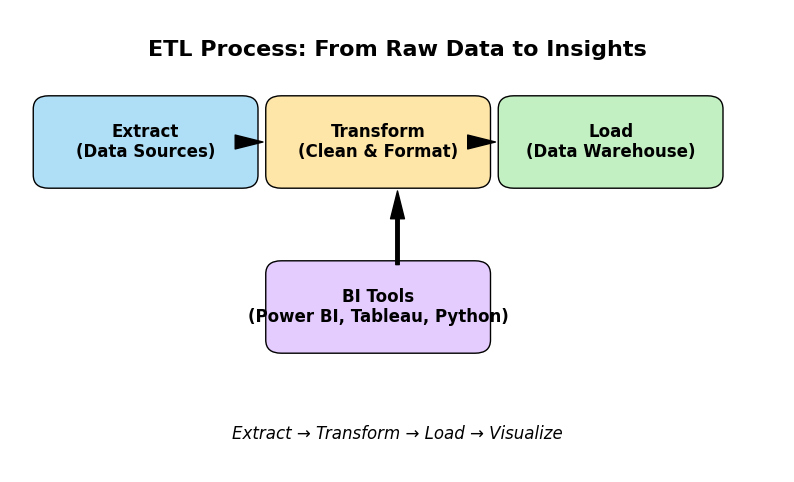

In [9]:

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ArrowStyle

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis('off')

# Helper function to draw boxes
def draw_box(x, y, text, color):
    box = FancyBboxPatch((x, y), 2.5, 1, boxstyle="round,pad=0.2", ec="black", fc=color)
    ax.add_patch(box)
    ax.text(x + 1.25, y + 0.5, text, ha="center", va="center", fontsize=12, weight="bold")

# Boxes
draw_box(0.5, 4.5, "Extract\n(Data Sources)", "#AEDFF7")
draw_box(3.5, 4.5, "Transform\n(Clean & Format)", "#FEE6A8")
draw_box(6.5, 4.5, "Load\n(Data Warehouse)", "#C2F0C2")
draw_box(3.5, 2, "BI Tools\n(Power BI, Tableau, Python)", "#E5CCFF")

# Arrows
arrow = ArrowStyle("Simple, tail_width=0.25, head_width=1, head_length=2")
ax.annotate('', xy=(3.3, 5), xytext=(2.9, 5), arrowprops=dict(arrowstyle=arrow, color='black'))
ax.annotate('', xy=(6.3, 5), xytext=(5.9, 5), arrowprops=dict(arrowstyle=arrow, color='black'))
ax.annotate('', xy=(5, 4.3), xytext=(5, 3.1), arrowprops=dict(arrowstyle=arrow, color='black'))

# Titles
ax.text(5, 6.3, "ETL Process: From Raw Data to Insights", fontsize=16, ha="center", weight="bold")
ax.text(5, 0.5, "Extract → Transform → Load → Visualize", fontsize=12, ha="center", style="italic")

plt.show()



## End-to-End ETL + Data Prep Demo (with Mini BI Viz)

This section demonstrates: **Extract → Transform → Load → Visualize** using Pandas and SQLite.


In [2]:

# 1) Setup & Imports
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path

# Keep output tidy
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 20)

project_dir = Path.cwd()
warehouse_path = project_dir / 'warehouse.sqlite3'



### 2) EXTRACT — Simulate source systems and read them

We will **generate** tiny source files to mimic real inputs:
- `customers.csv` (CSV from a CRM)
- `orders.json` (JSON from an e-commerce app)


In [3]:

# Generate tiny source datasets
customers_src = pd.DataFrame({
    'customer_id': [101, 102, 103, 104, 105],
    'name': ['Alice Smith', 'Bob Jones', 'Caro Lina', 'D. Johnson', 'Eve Adams'],
    'region': ['west', 'West ', 'EAST', 'north', None],                     # mixed case + a missing region
    'email': ['alice@example.com', 'bob@example.com', 'caro@example.com', 'djohnson@example.com', 'eve@example.com']
})

orders_src = pd.DataFrame({
    'order_id': [9001, 9002, 9003, 9004, 9005, 9006],
    'customer_id': [101, 101, 102, 104, 105, 999],                           # 999 will be an orphan not in customers
    'order_date': ['2025-01-15', '2025-02-03', '2025-02-20', '2025-03-09', None, '2025-01-05'],  # one missing date
    'sku': ['A-100', 'A-200', 'B-100', 'A-100', 'C-100', 'A-200'],
    'qty': [2, 1, 5, 3, 1, 4],
    'unit_price': [49.99, 199.00, 9.99, 49.99, 299.0, 199.0],
    'discount_pct': [0.10, 0.00, 0.05, 0.00, 0.15, 0.00]
})

# Persist to disk to mimic real extraction
customers_csv = project_dir / 'customers.csv'
orders_json = project_dir / 'orders.json'
customers_src.to_csv(customers_csv, index=False)
orders_src.to_json(orders_json, orient='records', lines=True)

# Read from the sources
customers = pd.read_csv(customers_csv)
orders = pd.read_json(orders_json, orient='records', lines=True)

print('Extracted customers:')
display(customers)
print('\nExtracted orders:')
display(orders)


Extracted customers:


,customer_id,name,region,email
0,101,Alice Smith,west,alice@example.com
1,102,Bob Jones,West,bob@example.com
2,103,Caro Lina,EAST,caro@example.com
3,104,D. Johnson,north,djohnson@example.com
4,105,Eve Adams,NaN,eve@example.com



Extracted orders:


,order_id,customer_id,order_date,sku,qty,unit_price,discount_pct
0,9001,101,2025-01-15,A-100,2,49.99,0.10
1,9002,101,2025-02-03,A-200,1,199.00,0.00
2,9003,102,2025-02-20,B-100,5,9.99,0.05
3,9004,104,2025-03-09,A-100,3,49.99,0.00
4,9005,105,None,C-100,1,299.00,0.15
5,9006,999,2025-01-05,A-200,4,199.00,0.00



### 3) TRANSFORM — Clean, standardize, derive metrics, and join

Common data prep operations:
- Normalize `region` text (trim + upper-case; impute missing)
- Parse dates and derive `order_month`
- Compute `line_total = qty * unit_price * (1 - discount_pct)`
- Remove orphan orders (no matching customer)
- Final **star-schema style** outputs: `dim_customers`, `fact_orders`, and an aggregated `sales_summary`


In [4]:

# Clean customers
customers['region'] = customers['region'].fillna('UNKNOWN').astype(str).str.strip().str.upper()

# Clean orders
orders['order_date'] = pd.to_datetime(orders['order_date'], errors='coerce')  # coerce invalid to NaT
orders = orders.dropna(subset=['order_date'])                                 # drop rows with missing dates
orders['order_month'] = orders['order_date'].dt.to_period('M').astype(str)
orders['line_total'] = orders['qty'] * orders['unit_price'] * (1 - orders['discount_pct'])

# Join (inner join removes orphans where customer_id not present)
fact_orders = (
    orders.merge(customers[['customer_id', 'region']], on='customer_id', how='inner')
)

# Derive a tidy customer dimension (deduped)
dim_customers = customers.drop_duplicates(subset=['customer_id']).copy()

# Aggregations typically used for BI
sales_by_region = (
    fact_orders.groupby('region', as_index=False)['line_total'].sum().rename(columns={'line_total': 'total_sales'})
)

sales_by_month = (
    fact_orders.groupby('order_month', as_index=False)['line_total'].sum().rename(columns={'line_total': 'total_sales'})
    .sort_values('order_month')
)

sales_summary = (
    fact_orders.groupby(['order_month', 'region'], as_index=False)['line_total'].sum()
    .rename(columns={'line_total': 'total_sales'})
)

print('Transformed fact_orders (preview):')
display(fact_orders.head())
print('\nSales by region:')
display(sales_by_region)
print('\nSales by month:')
display(sales_by_month)


Transformed fact_orders (preview):


,order_id,customer_id,order_date,sku,qty,unit_price,discount_pct,order_month,line_total,region
0,9001,101,2025-01-15,A-100,2,49.99,0.10,2025-01,89.9820,WEST
1,9002,101,2025-02-03,A-200,1,199.00,0.00,2025-02,199.0000,WEST
2,9003,102,2025-02-20,B-100,5,9.99,0.05,2025-02,47.4525,WEST
3,9004,104,2025-03-09,A-100,3,49.99,0.00,2025-03,149.9700,NORTH



Sales by region:


,region,total_sales
0,NORTH,149.9700
1,WEST,336.4345



Sales by month:


,order_month,total_sales
0,2025-01,89.9820
1,2025-02,246.4525
2,2025-03,149.9700



### 4) LOAD — Write curated data into a SQLite "warehouse"

We will load dimension, fact, and summary tables into **warehouse.sqlite3**.


In [5]:

# (Re)create a local SQLite warehouse and load tables
if warehouse_path.exists():
    os.remove(warehouse_path)

with sqlite3.connect(warehouse_path) as conn:
    dim_customers.to_sql('dim_customers', conn, index=False)
    fact_orders.to_sql('fact_orders', conn, index=False)
    sales_summary.to_sql('sales_summary', conn, index=False)

print(f"Loaded tables into: {warehouse_path}")

# Quick validation query
with sqlite3.connect(warehouse_path) as conn:
    chk = pd.read_sql(
        "SELECT region, SUM(total_sales) AS total_sales "
        "FROM sales_summary GROUP BY region ORDER BY total_sales DESC",
        conn
    )

print('Warehouse check — total sales by region:')
display(chk)


Loaded tables into: c:\Repos\data-project-01\warehouse.sqlite3
Warehouse check — total sales by region:


,region,total_sales
0,WEST,336.4345
1,NORTH,149.9700



### 5) VISUALIZE — Simple BI-style charts

- **Bar**: Total Sales by Region  
- **Line**: Total Sales by Month

*Note:* We intentionally do not set explicit colors in charts.


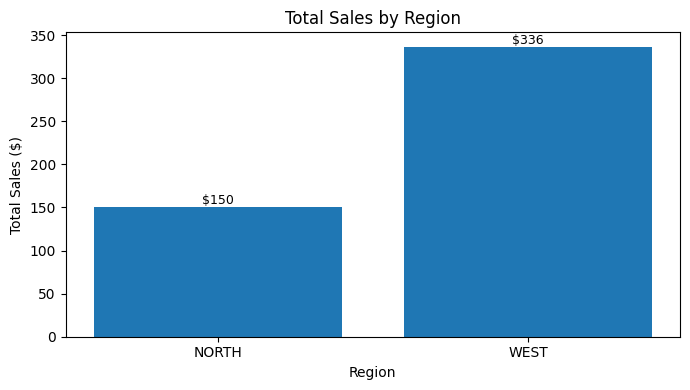

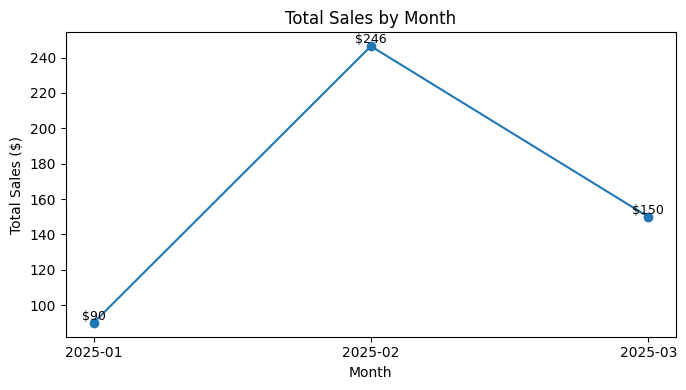

In [6]:

# Bar: Sales by Region
fig1, ax1 = plt.subplots(figsize=(7, 4))
ax1.bar(sales_by_region['region'], sales_by_region['total_sales'])
ax1.set_title('Total Sales by Region')
ax1.set_xlabel('Region')
ax1.set_ylabel('Total Sales ($)')
for x, y in zip(sales_by_region['region'], sales_by_region['total_sales']):
    ax1.text(x, y, f"${y:,.0f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Line: Sales by Month
fig2, ax2 = plt.subplots(figsize=(7, 4))
ax2.plot(sales_by_month['order_month'], sales_by_month['total_sales'], marker='o')
ax2.set_title('Total Sales by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Sales ($)')
for x, y in zip(sales_by_month['order_month'], sales_by_month['total_sales']):
    ax2.text(x, y, f"${y:,.0f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()



### 6) What to tweak next

- Add columns (e.g., `profit = revenue - cost`), tax calculations, or currency conversions.  
- Expand dimensions (e.g., product, channel) and create a full **star schema**.  
- Swap SQLite for a cloud warehouse (Snowflake/BigQuery/Redshift) and run the **ELT** step there.  
- Connect Power BI/Tableau directly to `warehouse.sqlite3` (or your cloud warehouse) for live dashboards.
